In [1]:
import json
import os
import matplotlib.pyplot as plt
import re
import numpy as np

In [4]:
experiments_path = '/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/Plots/experiments_1.json'

with open(experiments_path, 'r') as file:
    experiments = json.load(file)


In [5]:
def get_paths(algorithm, experiments, result_folder="results"):
    paths = []
    for key, value in experiments.items():
        if (value.get('algorithms') == algorithm and value.get("regularisation_weight") in (0.0, 0.001, 0.01, 0.1, 1, 10)): #and value.get('processor_type') != "mpnn_l1_regularised_max" 
            paths.append(f'/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/{result_folder}/{key}')
    return paths

def get_lines(file_to_read, entries, directory_path):
    if file_to_read in entries:
        file_path = os.path.join(directory_path, file_to_read)

    with open(file_path, 'r') as file:
        lines = file.readlines()
    return lines

def get_results(directory_path):
    entries = os.listdir(directory_path)

    lines = get_lines('slurm_experiment.out', entries, directory_path)

    pattern = re.compile(r'current loss ([\d\.]+)')
    test_score_pattern = re.compile(r"'score':\s*([\d\.e-]+)")
    val_score_pattern = re.compile(r"'score':\s*([\d\.e-]+)")

    loss_values = []
    for line in lines:
        match = pattern.search(line)
        if match:
            loss_value = float(match.group(1))
            loss_values.append(loss_value)
        
        match_test_score = test_score_pattern.search(line)
        if match_test_score and '(test)' in line:
            test_score_value = float(match_test_score.group(1))
        
        match_val_score = val_score_pattern.search(line)
        if match_val_score and '(val)' in line:
            val_score_value = float(match_val_score.group(1))

    lines = get_lines('slurm_output.out', entries, directory_path)
        
    processor_type_pattern = re.compile(r'processor_type (\S+)')
    regularisation_weight_pattern = re.compile(r'regularisation_weight ([\d\.]+(?:e-?\d+)?)')

    for line in lines:
        processor_type_match = processor_type_pattern.search(line)
        if processor_type_match:
            processor_type = str(processor_type_match.group(1))
            
        regularisation_weight_match = regularisation_weight_pattern.search(line)
        if regularisation_weight_match:
            regularisation_weight = regularisation_weight_match.group(1)

    lines = get_lines('experiment_log.out', entries, directory_path)

    regularised_loss_pattern = re.compile(r'Regularised loss:\s*([\d\.]+(?:e-?\d+)?)')
    mse_loss_pattern = re.compile(r'MSE loss:\s*([\d\.]+(?:e-?\d+)?)')
    quality_loss_pattern = re.compile(r'Quality loss:\s*([\d\.]+(?:e-?\d+)?)')


    regularised_loss_values = []
    mse_loss_values = []
    quality_loss_values= []
    for line in lines:
        regularised_loss_match = regularised_loss_pattern.search(line)
        mse_loss_match = mse_loss_pattern.search(line)
        quality_loss_match = quality_loss_pattern.search(line)

        if regularised_loss_match:
            regularised_loss = float(regularised_loss_match.group(1))
            regularised_loss_values.append(regularised_loss)

        if mse_loss_match:
            mse_loss = float(mse_loss_match.group(1))
            mse_loss_values.append(mse_loss)

        if quality_loss_match:
            quality_loss = float(quality_loss_match.group(1))
            quality_loss_values.append(quality_loss)
    
    return test_score_value, val_score_value, loss_values, regularised_loss_values, mse_loss_values, quality_loss_values, processor_type, regularisation_weight

def get_model_idx(processor_types, test_accuracies):
    highest_accuracy_info = {
        'mpnn_l1': {'accuracy': -1, 'index': None},
        'mpnn_l1_max': {'accuracy': -1, 'index': None},
        'mpnn_l2': {'accuracy': -1, 'index': None},
        'mpnn_l1_regularised': {'accuracy': -1, 'index': None},
        'mpnn_l1_regularised_max': {'accuracy': -1, 'index': None}
    }

    for i, (processor_type, accuracy) in enumerate(zip(processor_types, test_accuracies)):
        if processor_type in highest_accuracy_info:
            if accuracy > highest_accuracy_info[processor_type]['accuracy']:
                highest_accuracy_info[processor_type]['accuracy'] = accuracy
                highest_accuracy_info[processor_type]['index'] = i

    highest_accuracy_indices = {
        processor_type: info['index']
        for processor_type, info in highest_accuracy_info.items()
    }

    return (highest_accuracy_indices['mpnn_l1'], 
            highest_accuracy_indices['mpnn_l1_max'], 
            highest_accuracy_indices['mpnn_l2'], 
            highest_accuracy_indices['mpnn_l1_regularised'], 
            highest_accuracy_indices['mpnn_l1_regularised_max'])


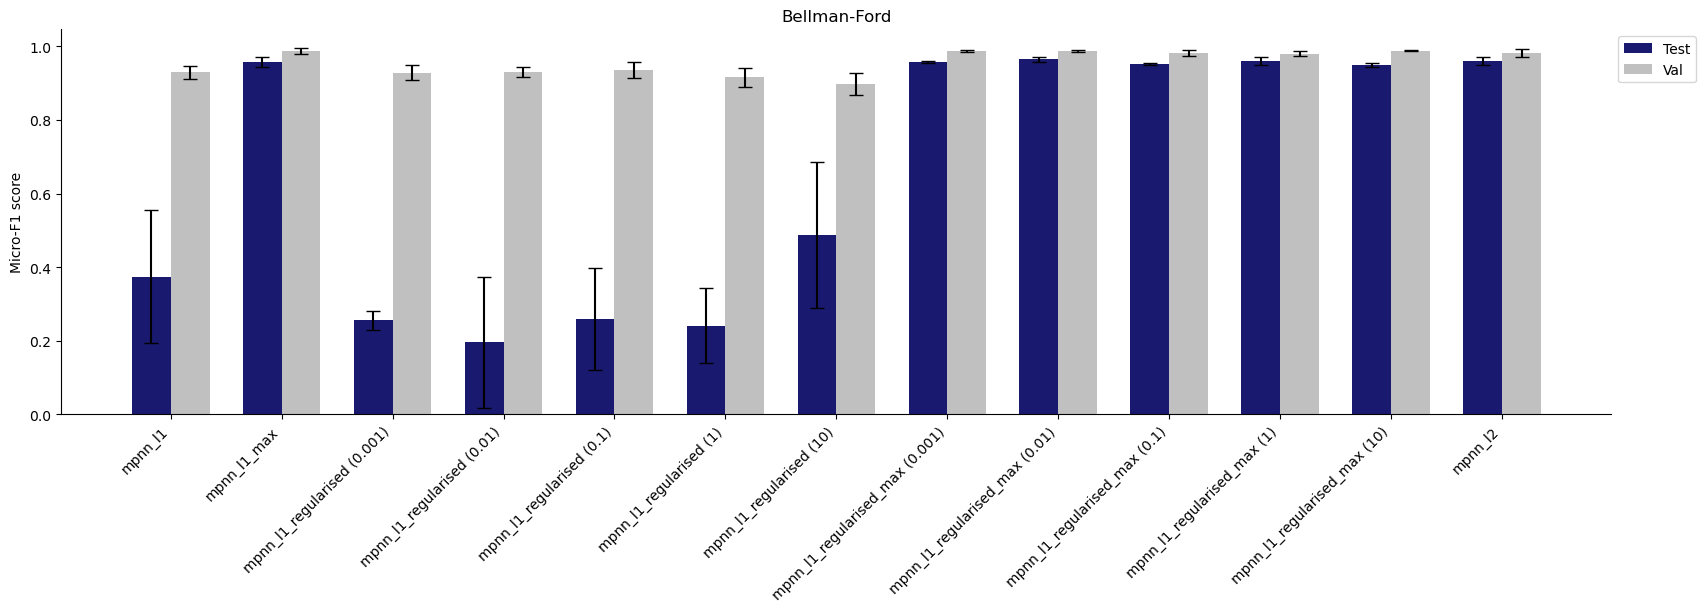

In [21]:
#QUANTITATIVE PLOT WITH ERROR BARS

result_folders = ['results', 'results_0', 'results_1']
algorithms = ['bellman_ford']

def get_sorted_results(alg, experiments, result_folder):
    paths = get_paths(alg, experiments, result_folder)

    test_accuracies = []
    val_accuracies = []
    processor_types = []
    regularisation_weights = []
    for path in paths:
        results = get_results(path)
        test_accuracies.append(results[0])
        val_accuracies.append(results[1])
        processor_types.append(results[-2])
        regularisation_weights.append(results[-1])

    processor_types_np = np.array(processor_types)
    regularisation_weights_np = np.array(regularisation_weights)   
    current_labels = [f'{proc_type}_{weight}' for proc_type, weight in zip(processor_types_np, regularisation_weights_np)] 
    new_order_labels = ['mpnn_l1_0.0','mpnn_l1_max_0.0','mpnn_l1_regularised_0.001','mpnn_l1_regularised_0.01','mpnn_l1_regularised_0.1', 'mpnn_l1_regularised_1','mpnn_l1_regularised_10','mpnn_l1_regularised_max_0.001','mpnn_l1_regularised_max_0.01','mpnn_l1_regularised_max_0.1', 'mpnn_l1_regularised_max_1','mpnn_l1_regularised_max_10', 'mpnn_l2_0.0']
    
    sorted_indices = [current_labels.index(label) for label in new_order_labels if label in current_labels]

    test_accuracies_np = np.array(test_accuracies)
    val_accuracies_np = np.array(val_accuracies)

    return (processor_types_np[sorted_indices], regularisation_weights_np[sorted_indices], 
            test_accuracies_np[sorted_indices], val_accuracies_np[sorted_indices])

aggregated_test_accuracies = []
aggregated_val_accuracies = []

# Loop over each folder and aggregate accuracies
for folder in result_folders:
    processor_types, regularisation_weights, test_accuracies, val_accuracies = get_sorted_results(algorithms[0], experiments, folder)
    aggregated_test_accuracies.append(test_accuracies)
    aggregated_val_accuracies.append(val_accuracies)

# Convert lists of lists into numpy arrays for easier manipulation
aggregated_test_accuracies_np = np.array(aggregated_test_accuracies)
aggregated_val_accuracies_np = np.array(aggregated_val_accuracies)

# Calculate mean and standard deviation across the result folders
mean_test_accuracies = np.mean(aggregated_test_accuracies_np, axis=0)
std_test_accuracies = np.std(aggregated_test_accuracies_np, axis=0)
mean_val_accuracies = np.mean(aggregated_val_accuracies_np, axis=0)
std_val_accuracies = np.std(aggregated_val_accuracies_np, axis=0)

#Plotting
labels = ['mpnn_l1','mpnn_l1_max','mpnn_l1_regularised (0.001)','mpnn_l1_regularised (0.01)','mpnn_l1_regularised (0.1)', 'mpnn_l1_regularised (1)','mpnn_l1_regularised (10)','mpnn_l1_regularised_max (0.001)','mpnn_l1_regularised_max (0.01)','mpnn_l1_regularised_max (0.1)', 'mpnn_l1_regularised_max (1)','mpnn_l1_regularised_max (10)', 'mpnn_l2']



x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,5))
rects1 = ax.bar(x - width/2, mean_test_accuracies, width, yerr=std_test_accuracies, label='Test', color='midnightblue', capsize=5)
rects2 = ax.bar(x + width/2, mean_val_accuracies, width, yerr=std_val_accuracies, label='Val', color='silver', capsize=5)

ax.set_ylabel('Micro-F1 score')
ax.set_title('Bellman-Ford')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



In [ ]:
#SAVE LOSS PLOTS
algorithms = ['bellman_ford', 'bfs', 'lcs_length', 'dijkstra', 'activity_selector'] #'bellman_ford', 'bfs', 'lcs_length', 'dijkstra',  ,
figsize=(30,10)
for i, alg in enumerate(algorithms):
    paths = get_paths(alg, experiments)

    test_accuracies = []
    quality_loss = []
    regularised_loss = []
    mse_loss = []
    processor_types = []
    regularisation_weights = []
    for path in paths:
        results = get_results(path)
        quality_loss.append(results[5])
        regularised_loss.append(results[3])
        mse_loss.append(results[4])
        test_accuracies.append(results[0])
        processor_types.append(results[-2])
        regularisation_weights.append(results[-1])
    

    idx = get_model_idx(processor_types, test_accuracies)
    quality_loss_reduced = [quality_loss[i] for i in idx]
    regularised_loss_reduced = [regularised_loss[i] for i in idx]
    mse_loss_reduced = [mse_loss[i] for i in idx]
    processor_types_reduced = [processor_types[i] for i in idx]
    regularisation_weights_reduced = [regularisation_weights[i] for i in idx]

    mse_dir = f"/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/Plots/27_2/{alg}/mse_losses/"
    if not os.path.exists(mse_dir):
        os.makedirs(mse_dir)

    reg_dir = f"/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/Plots/27_2/{alg}/regularised_losses/"
    if not os.path.exists(reg_dir):
        os.makedirs(reg_dir)

    quality_dir = f"/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/Plots/27_2/{alg}/quality_losses/"
    if not os.path.exists(quality_dir):
        os.makedirs(quality_dir)
    
    reg_qual_dir = f"/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/Plots/27_2/{alg}/quality+regularisation_losses/"
    if not os.path.exists(reg_qual_dir):
        os.makedirs(reg_qual_dir)

    mse_qual_dir = f"/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/Plots/27_2/{alg}/quality+mse_losses/"
    if not os.path.exists(mse_qual_dir):
        os.makedirs(mse_qual_dir)
    

    mse_reg_dir = f"/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/Plots/27_2/{alg}/regularisation+mse_losses/"
    if not os.path.exists(mse_reg_dir):
        os.makedirs(mse_reg_dir)
    
    mse_reg_qual_dir = f"/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/Plots/27_2/{alg}/regularisation+mse_quality_losses/"
    if not os.path.exists(mse_reg_qual_dir):
        os.makedirs(mse_reg_qual_dir)
            
            
            

    mse_dir_log = f"/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/Plots/27_2/{alg}/mse_losses_log/"
    if not os.path.exists(mse_dir_log):
        os.makedirs(mse_dir_log)

    reg_dir_log = f"/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/Plots/27_2/{alg}/regularised_losses_log/"
    if not os.path.exists(reg_dir_log):
        os.makedirs(reg_dir_log)

    
    quality_dir_log = f"/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/Plots/27_2/{alg}/quality_losses_log/"
    if not os.path.exists(quality_dir_log):
        os.makedirs(quality_dir_log)
    
    reg_qual_dir_log = f"/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/Plots/27_2/{alg}/quality+regularisation_losses_log/"
    if not os.path.exists(reg_qual_dir_log):
        os.makedirs(reg_qual_dir_log)
    

    mse_qual_dir_log = f"/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/Plots/27_2/{alg}/quality+mse_losses_log/"
    if not os.path.exists(mse_qual_dir_log):
        os.makedirs(mse_qual_dir_log)
    

    mse_reg_dir_log = f"/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/Plots/27_2/{alg}/regularisation+mse_losses_log/"
    if not os.path.exists(mse_reg_dir_log):
        os.makedirs(mse_reg_dir_log)
    
    mse_reg_qual_dir_log = f"/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/Plots/27_2/{alg}/regularisation+mse_quality_losses_log/"
    if not os.path.exists(mse_reg_qual_dir_log):
        os.makedirs(mse_reg_qual_dir_log)
            
            

    for i in range(len(processor_types)):
        plt.figure(figsize=figsize)
        #plt.plot(quality_loss[i], label='quality_loss')
        plt.plot(mse_loss[i], label=f'mse_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.legend()
        plt.savefig(f"{mse_dir}{alg}_{processor_types[i]}_{regularisation_weights[i]}.png") 

        plt.figure(figsize=figsize)
        plt.plot(regularised_loss[i], label=f'regularised_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.legend()
        plt.savefig(f"{reg_dir}{alg}_{processor_types[i]}_{regularisation_weights[i]}.png")

        plt.figure(figsize=figsize)
        plt.plot(quality_loss[i], label=f'quality_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.legend()
        plt.savefig(f"{quality_dir}{alg}_{processor_types[i]}_{regularisation_weights[i]}.png")  

        plt.figure(figsize=figsize)
        plt.plot(quality_loss[i], label=f'quality_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.plot(regularised_loss[i], label=f'regularised_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.legend()
        plt.savefig(f"{reg_qual_dir}{alg}_{processor_types[i]}_{regularisation_weights[i]}.png")  

        plt.figure(figsize=figsize)
        plt.plot(quality_loss[i], label=f'quality_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.plot(mse_loss[i], label=f'mse_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.legend()
        plt.savefig(f"{mse_qual_dir}{alg}_{processor_types[i]}_{regularisation_weights[i]}.png")  

        plt.figure(figsize=figsize)
        plt.plot(regularised_loss[i], label=f'regularised_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.plot(mse_loss[i], label=f'mse_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.legend()
        plt.savefig(f"{mse_reg_dir}{alg}_{processor_types[i]}_{regularisation_weights[i]}.png")  


        plt.figure(figsize=figsize)
        plt.plot(regularised_loss[i], label=f'regularised_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.plot(mse_loss[i], label=f'mse_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.plot(quality_loss[i], label=f'quality_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.legend()
        plt.savefig(f"{mse_reg_qual_dir}{alg}_{processor_types[i]}_{regularisation_weights[i]}.png")  



        ####


        plt.figure(figsize=figsize)
        #plt.plot(quality_loss[i], label='quality_loss')
        plt.semilogy(mse_loss[i], label=f'mse_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.legend()
        plt.savefig(f"{mse_dir_log}{alg}_{processor_types[i]}_{regularisation_weights[i]}.png") 

        plt.figure(figsize=figsize)
        plt.semilogy(regularised_loss[i], label=f'regularised_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.legend()
        plt.savefig(f"{reg_dir_log}{alg}_{processor_types[i]}_{regularisation_weights[i]}.png")

        plt.figure(figsize=figsize)
        plt.semilogy(quality_loss[i], label=f'quality_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.legend()
        plt.savefig(f"{quality_dir_log}{alg}_{processor_types[i]}_{regularisation_weights[i]}.png")  

        plt.figure(figsize=figsize)
        plt.semilogy(quality_loss[i], label=f'quality_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.semilogy(regularised_loss[i], label=f'regularised_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.legend()
        plt.savefig(f"{reg_qual_dir_log}{alg}_{processor_types[i]}_{regularisation_weights[i]}.png")  

        plt.figure(figsize=figsize)
        plt.semilogy(quality_loss[i], label=f'quality_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.semilogy(mse_loss[i], label=f'mse_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.legend()
        plt.savefig(f"{mse_qual_dir_log}{alg}_{processor_types[i]}_{regularisation_weights[i]}.png")  

        plt.figure(figsize=figsize)
        plt.semilogy(regularised_loss[i], label=f'regularised_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.semilogy(mse_loss[i], label=f'mse_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.legend()
        plt.savefig(f"{mse_reg_dir_log}{alg}_{processor_types[i]}_{regularisation_weights[i]}.png")  

        plt.figure(figsize=figsize)
        plt.semilogy(regularised_loss[i], label=f'regularised_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.semilogy(mse_loss[i], label=f'mse_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.semilogy(quality_loss[i], label=f'quality_loss for {processor_types[i]} - {regularisation_weights[i]}')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.legend()
        plt.savefig(f"{mse_reg_qual_dir_log}{alg}_{processor_types[i]}_{regularisation_weights[i]}.png")  

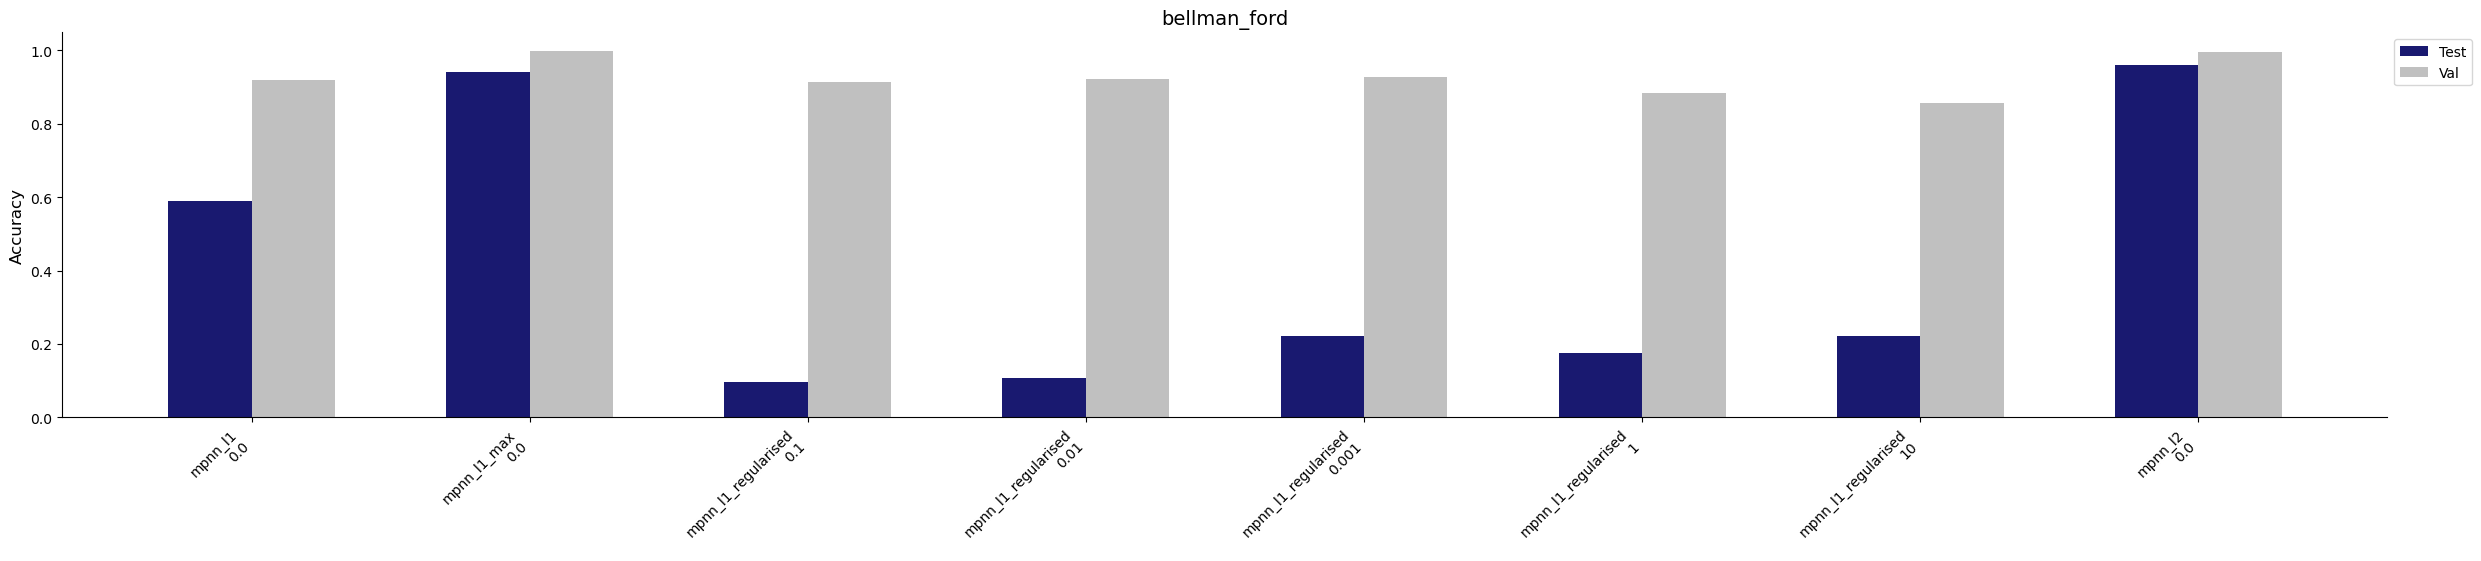

In [17]:
#QUANTITATIVE PLOT (SINGLE SEED)
algorithms = ['bellman_ford'] #, 'bfs', 'lcs_length', 'dijkstra', 'activity_selector'

for i, alg in enumerate(algorithms):
    
    paths = get_paths(alg, experiments)

    test_accuracies = []
    val_accuracies = []
    processor_types = []
    regularisation_weights = []
    for path in paths:
        results = get_results(path)
        test_accuracies.append(results[0])
        val_accuracies.append(results[1])
        processor_types.append(results[-2])
        regularisation_weights.append(results[-1])



    processor_types_np = np.array(processor_types)
    regularisation_weights_np = np.array(regularisation_weights)
    test_accuracies_np = np.array(test_accuracies)
    val_accuracies_np = np.array(val_accuracies)

    sorted_indices = np.argsort(processor_types_np)

    sorted_processor_types = processor_types_np[sorted_indices]
    sorted_regularisation_weights = regularisation_weights_np[sorted_indices]
    sorted_test_accuracies = test_accuracies_np[sorted_indices]
    sorted_val_accuracies = val_accuracies_np[sorted_indices]

    processor_types = list(sorted_processor_types)
    regularisation_weights = list(sorted_regularisation_weights)
    test_accuracies = list(sorted_test_accuracies)
    val_accuracies = list(sorted_val_accuracies)


    labels = [f'{proc_type}\n{weight}' for proc_type, weight in zip(processor_types, regularisation_weights)]
    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots(figsize=(30,5))
    rects1 = ax.bar(x - width/2, test_accuracies, width, label='Test', color='midnightblue')
    rects2 = ax.bar(x + width/2, val_accuracies, width, label='Val', color='silver')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy', fontsize=12) #fontsize=14
    ax.set_title(f'{alg}', fontsize=14) # fontsize=16
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #plt.subplots_adjust(top=0.9, bottom=0.1) 



ENDS HERE

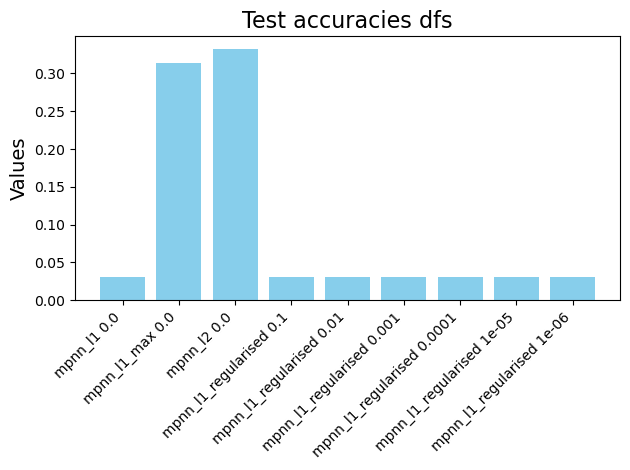

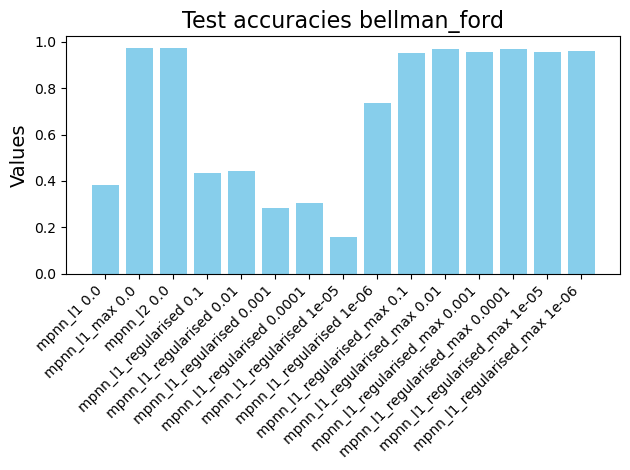

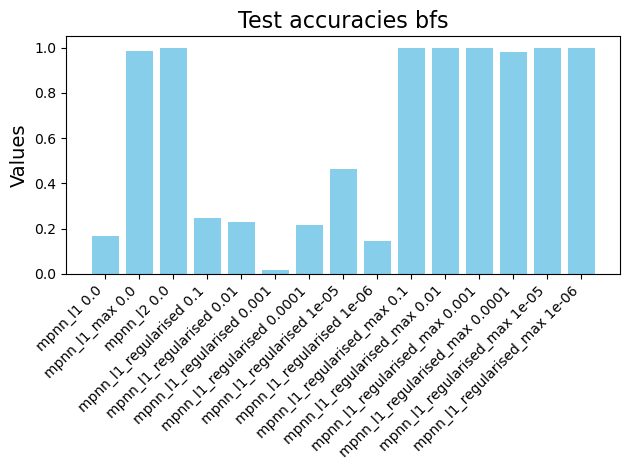

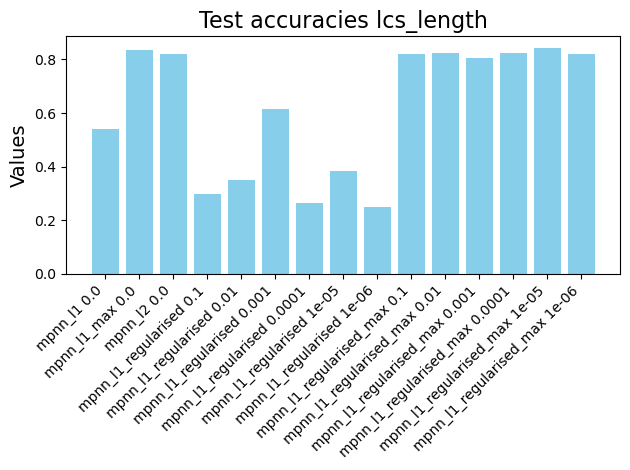

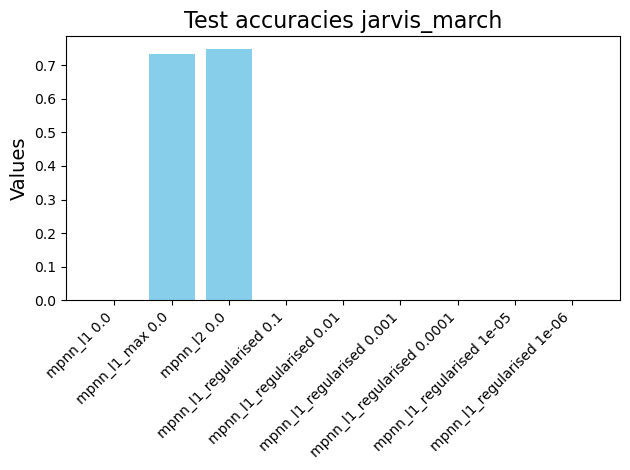

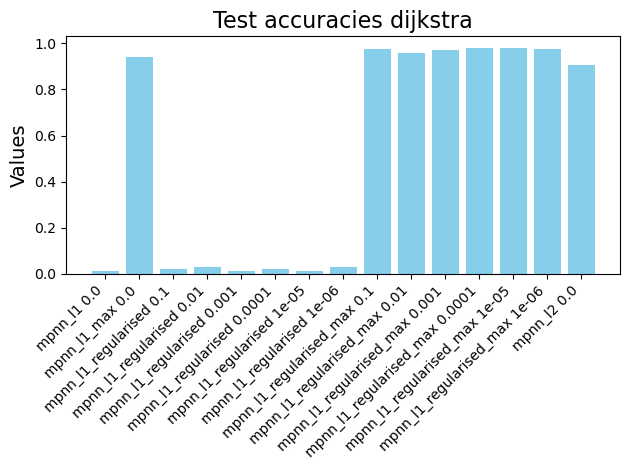

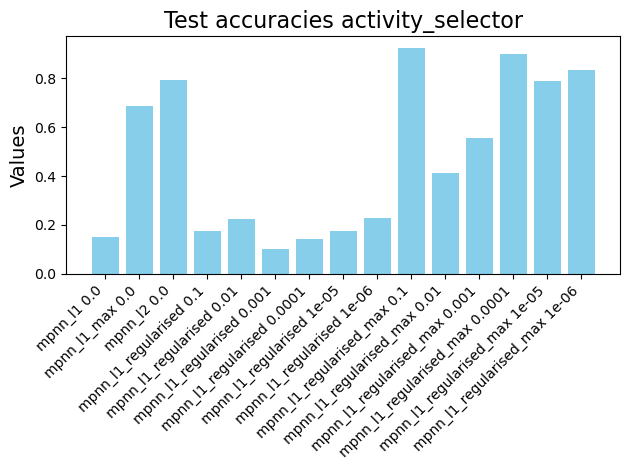

In [4]:
algorithms =  ['dfs','bellman_ford', 'bfs','lcs_length', 'jarvis_march', 'dijkstra', 'activity_selector'] #['dfs', 'bfs', 'bellman_ford', 'max_subarray', 'lcs_length', 'jarvis_march']

for i, alg in enumerate(algorithms):
    paths = get_paths(alg, experiments)

    test_accuracies = []
    val_accuracies = []
    processor_types = []
    regularisation_weights = []
    for path in paths:
        results = get_results(path)
        test_accuracies.append(results[0])
        val_accuracies.append(results[1])
        processor_types.append(results[-2])
        regularisation_weights.append(results[-1])

    labels = [f'{proc_type} {weight}' for proc_type, weight in zip(processor_types, regularisation_weights)]

    plt.figure()
    plt.bar(labels, test_accuracies, color='skyblue')
    plt.ylabel('Values', fontsize=14)
    plt.title(f'Test accuracies {alg}', fontsize=16)
    plt.xticks(rotation=45, ha="right") 
    plt.tight_layout()  
    

In [83]:
score_value, loss_values, regularised_loss_values, mse_loss_values, quality_loss_values, processor_type, regularisation_weight = get_results('/Users/ariellerosinski/My Drive/Cambridge/L65 Geometric DL/Project/Code/results/18')

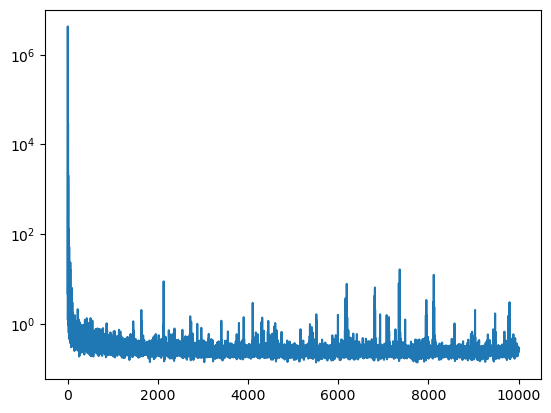

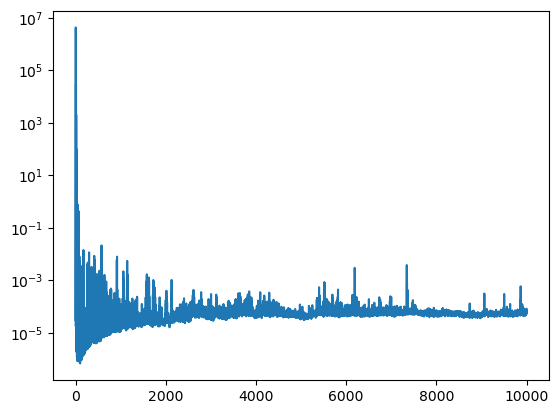

In [84]:
plt.semilogy(loss_values)
plt.figure()
plt.semilogy(regularised_loss_values)